![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Functions

In [4]:
def data_description(df: pd.DataFrame) -> None:
    ''' Выводит дополнительную информацию о пустых полях в датасете. '''

    print("Размерность набора (строки, столбцы):", df.shape, "\n")
    print("Кол-во полных дубликатов:", df[df.duplicated()].shape[0])
    print(
        "Кол-во пустых строк:     ", df[df.isna().all(axis="columns")].shape[0]
    )
    print(
        "Кол-во строк, имеющих хотя бы одно пустое значение:",
        df[df.isna().any(axis="columns")].shape[0],
    )
    print(
        "Кол-во строк, не имеющих ни одного пустого значения:",
        df[df.notna().all(axis="columns")].shape[0],
        "\n",
    )
    print("Информация о пустых значениях по столбцам (в процентах):")
    display(df.isna().mean() * 100)
    #display(df.isna().agg(['sum', 'mean']).T) 
    #print("   желтый - пропущенные данные, синий - не пустые")
    # Посмотрим как распеделены пропуски по датасету:
    #plt.figure(figsize=(10, 7)) # размер тепловой карты
    #sns.heatmap(df.isnull(), cmap="YlGnBu_r")
    return None


def field_values(df: pd.DataFrame, column: object, uval: int=15, table: bool=True) -> None :
    ''' Выводит информацию о типе данных в колонке, кол-во уникальных значений и
    кол-во NaN. А также, если кол-во уникальных значений меньше uval, выводит 
    список всех возможных значений в колонке, отcортированных по значениям, а 
    не по кол-ву, иначе сортировка по кол-ву.
    '''
    print(column,': ', type(df[column][0]))
    uniqval = df[column].nunique()
    print('Уникальных значений ', uniqval, ' из', df.shape[0] )
    print('NaN ', df[column].isna().sum(), "(",
            round(df[column].isna().mean() * 100, 2),
            "% )")
    if table:
        if uniqval > 10 :
            display(df[column].value_counts().head(6))
        else:
            display(df.groupby([column])[column].count())

    return None


def IQR_hist(df: pd.DataFrame, column: object, outliers: bool=False) -> None :
    ''' Строит гистограмму и выводит все числовые значения для оценки наличия выбросов '''

    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    iqr_low = perc25 - 1.5 * IQR
    iqr_up = perc75 + 1.5 * IQR
    min_value = df[column].min()
    max_value = df[column].max()
    print(
        "Среднее: {},".format(round(df[column].mean(), 2)),
        "Медиана: {},".format(round(df[column].median(), 2)),
        "Мода: {},".format(list(df[column].mode())),
    )
    print(
        "25-й перцентиль: {},".format(perc25),
        "75-й перцентиль: {},".format(perc75),
        "IQR: {}.".format(IQR),
    )
    print("Минимум/максимум: [{x}, {y}].".format(x=min_value, y=max_value))
    print("Границы выбросов: [{f}, {l}].".format(f=iqr_low, l=iqr_up))

    if outliers:
        ser = df[column].loc[df[column].between(min_value, max_value)].copy()
        nbins = ser.value_counts().count()
        ser.loc[(ser < iqr_low) | (ser > iqr_up)].hist(
            bins=nbins,
            range=(min_value, max_value),
            color="red",
            label="outliers",
        )
        ser.loc[ser.between(iqr_low, iqr_up)].hist(
            bins=nbins, range=(min_value, max_value), label="IQR"
        )
    else:
        min_interval = max(min_value, iqr_low)
        max_interval = min(max_value, iqr_up)
        ser = (
            df[column]
            .loc[df[column].between(min_interval, max_interval)]
            .copy()
        )
        nbins = ser.value_counts().count()
        ser.hist(bins=nbins, range=(min_interval, max_interval), label="IQR")
    plt.legend()

    return None


def get_boxplot(df: pd.DataFrame, column: object, target: str="Rating") -> None:
    ''' Отображет коробку с усами '''
    if df[column].value_counts().count() < 3:
        fig, ax = plt.subplots(figsize=(10, 3))
    else:
        fig, ax = plt.subplots(figsize=(12, 4))
    sns.boxplot(x=column, y=target, data=df, ax=ax)
    plt.xticks(rotation=45)
    ax.set_title("Boxplot for " + column)
    plt.show()

    return None


def del_object_type(df_input: pd.DataFrame,) -> pd.DataFrame:
    ''' Создаем копию df_input и убираем из копии признаки с dtypes <object> '''    
    df_output = df_input.copy()  

    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

# DATA

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0 

# объединяем
data = df_test.append(df_train, sort=False).reset_index(drop=True) 

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [14]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
48751,id_2479,Paris,"['French', 'European', 'Wine Bar']",2480.0,$$ - $$$,113.0,"[['Not what we were looking for', 'NIce place,...",/Restaurant_Review-g187147-d6584373-Reviews-Le...,d6584373,1,4.0
37685,id_117,Oporto,"['European', 'Portuguese', 'Soups']",118.0,$,448.0,"[['Just ace', 'So tasty! Love it'], ['02/19/20...",/Restaurant_Review-g189180-d1748939-Reviews-No...,d1748939,1,4.5
1567,id_1567,Madrid,NaN,7392.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187514-d13328807-Reviews-C...,d13328807,0,0.0
27001,id_4620,Barcelona,"['Mediterranean', 'Spanish']",4621.0,$,26.0,"[[""Don't eat like a tourist -- visit here!"", '...",/Restaurant_Review-g187497-d2361542-Reviews-Ba...,d2361542,1,3.5
28825,id_660,Edinburgh,"['Cafe', 'Mediterranean', 'Turkish', 'Vegan Op...",661.0,$,83.0,"[[""I'm a regular because it's great!"", 'Fringe...",/Restaurant_Review-g186525-d5850439-Reviews-Ol...,d5850439,1,4.5


In [15]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

In [16]:
# Приведем названия колонок к нормальному виду:
#data.columns = [s.lower() for s in data.columns]
data.columns = [s.replace(' ', '_') for s in data.columns]
data.columns

Index(['Restaurant_id', 'City', 'Cuisine_Style', 'Ranking', 'Price_Range',
       'Number_of_Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

In [17]:
# Посмотрим чуть более подробно на пустые значения во всем наборе
data_description(data)

Размерность набора (строки, столбцы): (50000, 11) 

Кол-во полных дубликатов: 0
Кол-во пустых строк:      0
Кол-во строк, имеющих хотя бы одно пустое значение: 17891
Кол-во строк, не имеющих ни одного пустого значения: 32109 

Информация о пустых значениях по столбцам (в процентах):


Restaurant_id         0.000
City                  0.000
Cuisine_Style        23.180
Ranking               0.000
Price_Range          34.722
Number_of_Reviews     6.400
Reviews               0.004
URL_TA                0.000
ID_TA                 0.000
sample                0.000
Rating                0.000
dtype: float64

Как можно увидеть, у нас достаточно много строк имеющих пропуски (32109 из 50000).
И все они в четырех колонках с пропусками: cuisine_style, price_range, number_of_reviews и reviews.
Позже обработаем каждую из них.

У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

## Обработка признаков

### 1 City_population

In [18]:
# Добавим признак населения по городу (в тыс.), источник worldcities.csv с simplemaps.com
city_population = {'London': 10979, 'Paris': 11020, 'Madrid': 3266, 'Barcelona': 4588,
                   'Berlin': 3645, 'Milan': 1352, 'Rome': 2873, 'Prague': 1324,
                   'Lisbon': 507, 'Vienna': 1841, 'Amsterdam': 1031, 'Brussels': 185,
                   'Hamburg': 1841, 'Munich': 1472, 'Lyon': 516, 'Stockholm': 973,
                  'Budapest': 1752, 'Warsaw': 1791, 'Dublin': 1173,
                  'Copenhagen': 1085, 'Athens': 664, 'Edinburgh': 488,
                  'Zurich': 434, 'Oporto': 233, 'Geneva': 201, 'Krakow': 767,
                  'Oslo': 693, 'Helsinki': 642, 'Bratislava': 429,
                 'Luxembourg': 122, 'Ljubljana': 284}

data['City_population'] = data['City'].map(city_population)
field_values(data, 'City_population')

City_population :  <class 'numpy.int64'>
Уникальных значений  30  из 50000
NaN  0 ( 0.0 % )


10979    7193
11020    6108
3266     3813
4588     3395
3645     2705
1352     2694
Name: City_population, dtype: int64

### 2 Restaurant_id

In [19]:
# Посмотрим на значения в этом столбце
field_values(data, 'Restaurant_id')


# Создадим новый признак Restaurant_Chain: 1 - сетевой, 0 - несетевой.
chain_list = data['Restaurant_id'].value_counts(
)[data['Restaurant_id'].value_counts() > 1].index

data['Restaurant_Chain'] = data['Restaurant_id'].apply(
    lambda x: 1 if x in chain_list else 0)

field_values(data, 'Restaurant_Chain')

Restaurant_id :  <class 'str'>
Уникальных значений  13094  из 50000
NaN  0 ( 0.0 % )


id_436    19
id_227    19
id_633    19
id_871    19
id_321    18
id_534    18
Name: Restaurant_id, dtype: int64

Restaurant_Chain :  <class 'numpy.int64'>
Уникальных значений  2  из 50000
NaN  0 ( 0.0 % )


Restaurant_Chain
0     3807
1    46193
Name: Restaurant_Chain, dtype: int64

### 3 Price_Range

In [20]:
# Посмотрим на значения в этом столбце
field_values(data, 'Price_Range')

# В колонке price_range 17361 (34.72%) пропущенных значений 
# Создадим новый булевый столбец cuisine_style_nan, чтобы не потерять данные
data['Price_Range_nan'] = pd.isna(data['Price_Range']).astype('uint8')

# Переведем столбец с ценовой категорией в числовой формат
price_dict = {'$$$$': 3,
              '$$ - $$$': 2, 
              '$': 1}
data['Price_Range'] = data['Price_Range'].replace(to_replace=price_dict)

# Заполним NaN медианой по городу
df = data.groupby('City')['Price_Range'].median()
data['Price_Range'].fillna(data['City'].apply(lambda x: df.loc[x]), inplace=True)

# Заполним NaN 0
#data['Price_Range'].fillna(0, inplace=True)

# и проверим 
field_values(data, 'Price_Range') 

Price_Range :  <class 'str'>
Уникальных значений  3  из 50000
NaN  17361 ( 34.72 % )


Price_Range
$            7816
$$ - $$$    23041
$$$$         1782
Name: Price_Range, dtype: int64

Price_Range :  <class 'numpy.float64'>
Уникальных значений  3  из 50000
NaN  0 ( 0.0 % )


Price_Range
1.0     7816
2.0    40402
3.0     1782
Name: Price_Range, dtype: int64

### 4 Number_of_Reviews

In [21]:
# Посмотрим на значения в этом столбце
field_values(data, 'Number_of_Reviews')

# В колонке Number_of_reviews 3200 (6.4%) пропущенных значений 
# Создадим новый булевый столбец Number_of_reviews_nan, чтобы не потерять данные
data['Number_of_Reviews_nan'] = pd.isna(
    data['Number_of_Reviews']).astype('uint8')


#df = data.groupby(['City'])['Number_of_Reviews'].mean().round()
df = data.groupby(['City'])['Number_of_Reviews'].median().round()

# Заполним NaN медианой по каждому городу (с mean и 0 чуть хуже результат)
data['Number_of_Reviews'].fillna(
    data['City'].apply(lambda x: df.loc[x]), inplace=True)

#data['Number_of_Reviews'].fillna(0, inplace=True)

# Создадим новую колонку Кол-во ревью на 1000 чел проживающих в этом городе
data['Reviews_per_population'] = data['Number_of_Reviews'] / data['City_population']

# проверим     
field_values(data, 'Number_of_Reviews', table=False)

Number_of_Reviews :  <class 'numpy.float64'>
Уникальных значений  1573  из 50000
NaN  3200 ( 6.4 % )


2.0    2403
3.0    2042
4.0    1707
5.0    1471
6.0    1258
7.0    1126
Name: Number_of_Reviews, dtype: int64

Number_of_Reviews :  <class 'numpy.float64'>
Уникальных значений  1573  из 50000
NaN  0 ( 0.0 % )


Среднее: 118.56, Медиана: 32.0, Мода: [2.0],
25-й перцентиль: 10.0, 75-й перцентиль: 106.0, IQR: 96.0.
Минимум/максимум: [2.0, 9660.0].
Границы выбросов: [-134.0, 250.0].


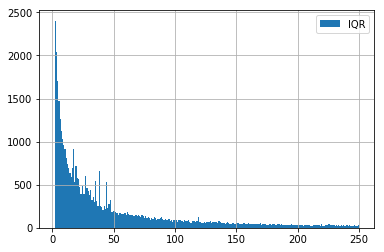

In [22]:
IQR_hist(data, 'Number_of_Reviews')

### 5 Ranking

In [23]:
# Посмотрим на значения в этом столбце
field_values(data,'Ranking')

# Определим относительный ранг для ресторана внутри города
df = data.groupby(['City'])['Ranking'].agg(
    ['min', 'max', 'mean', 'std']).reset_index()
data = data.merge(df, on='City', how='left')
data['Rank_Norm_minmax'] = (
    data['Ranking']-data['min']) / (data['max']-data['min'])

# MAE чуть лучше с minmax, std - убираем
#data['Rank_Norm_std'] = (data['Ranking']-data['mean']) / data['std']

# Создадим Ранг на 1000 человек в городе
data['Rank_per_population'] =  data['Ranking'] / data['City_population']

# Удалим ненужные колонки
data.drop(columns=['Ranking','min','max','mean','std'], inplace=True)

Ranking :  <class 'numpy.float64'>
Уникальных значений  12975  из 50000
NaN  0 ( 0.0 % )


93.0      22
72.0      21
491.0     21
842.0     21
1013.0    20
502.0     20
Name: Ranking, dtype: int64

### 6 Reviews

In [24]:
# Посмотрим на значения в этом столбце
field_values(data, 'Reviews')

# В колонке reviews всего 2 (0.004%) пропущенных значения
# Не будем создавать отдельный булевый столбец Reviews_nan

# Заполним эти 2 пропуска значением '[[], []]'
data['Reviews'].fillna('[[], []]', inplace=True)
field_values(data, 'Reviews', table=False)

Reviews :  <class 'str'>
Уникальных значений  41857  из 50000
NaN  2 ( 0.0 % )


[[], []]                                                                                   8112
[['Great Asian Option', 'Wow'], ['10/16/2017', '09/07/2016']]                                 2
[['The real codido madrileño'], ['03/31/2017']]                                               2
[['Good Paella', 'Good enough. Nothing more'], ['09/20/2017', '05/29/2017']]                  2
[['Great Food! Wide Variety.', 'Dinner'], ['11/26/2017', '05/23/2017']]                       2
[['Thursday snack', 'Good value for money & good food!'], ['03/13/2017', '06/20/2016']]       2
Name: Reviews, dtype: int64

Reviews :  <class 'str'>
Уникальных значений  41857  из 50000
NaN  0 ( 0.0 % )


In [25]:
# Определим список дат для отзывов (сначало берем второй вложенный список 
#  и уже в нем убираем лишние символы, даты из первого вложенного списка 
#  к нам не попадают)
data['Reviews_Dates_list'] = data['Reviews'].apply(lambda x: str(x)[str(
    x).rfind('[', 3)+1:-2]).str.replace(r"[',]", '', regex=True).str.split()

# Проверим, что получили список с двумя или одной датой или пустой
display(data['Reviews_Dates_list'].str.len().value_counts())

# Преобразуем список в поля с типом дата (Data_1 и Data_2)
data['Date_1'] = pd.to_datetime(data['Reviews_Dates_list'].apply(
    lambda x: x[0] if len(x) > 0 else None))
data['Date_2'] = pd.to_datetime(data['Reviews_Dates_list'].apply(
    lambda x: x[-1] if len(x) > 0 else None))

# Определим минимальную дату и заполним ей пропуске в Data_min и Data_max
date_min = min(data['Date_1'].min(), data['Date_2'].min())
data['Date_1'].fillna(date_min, inplace=True)
data['Date_2'].fillna(date_min, inplace=True)

# Создадим колонку с разницой между двумя датами в днях
data['Reviews_Days_delta'] = abs(data['Date_1'] - data['Date_2']).dt.days

# Создаем колонку с количеством дней, отделяющих последний отзыв от Date_max
date_max = max(data['Date_1'].max(), data['Date_2'].max())
data['Reviews_Days_from_max'] = data.apply(lambda r: date_max - max(
    r['Date_1'], r['Date_2']), axis=1).dt.days

# Создадим новый столбец с кол-вом отзывов 
# data[['Reviews_Dates_count','Reviews_Days_from_max']].corr()
# (корреляция с Reviews_Days_from_max больше 0.9 по модулю)
# уберем этот столбец, тем более
#data['Reviews_Dates_count'] = data['Reviews_Dates_list'].str.len()

# Удалим ненужные столбцы
data.drop(columns=['Reviews_Dates_list', 'Date_1',
          'Date_2', 'Reviews'], inplace=True)

2    36206
0     8114
1     5680
Name: Reviews_Dates_list, dtype: int64

### 7 URL_TA, ID_TA

In [26]:
# Посмотрим на значения в этих столбцах
field_values(data, 'URL_TA')
field_values(data, 'ID_TA')

URL_TA :  <class 'str'>
Уникальных значений  49963  из 50000
NaN  0 ( 0.0 % )


/Restaurant_Review-g187514-d4914988-Reviews-Xiang_Asia_Restaurant-Madrid.html      2
/Restaurant_Review-g187514-d4748208-Reviews-Restaurante_Te_Oriental-Madrid.html    2
/Restaurant_Review-g187514-d10047799-Reviews-Entrepuntos-Madrid.html               2
/Restaurant_Review-g187514-d9877640-Reviews-Raku_Sushi-Madrid.html                 2
/Restaurant_Review-g187514-d5617412-Reviews-Green_Marta_Iii-Madrid.html            2
/Restaurant_Review-g187514-d1028622-Reviews-La_Terraza_del_Urban-Madrid.html       2
Name: URL_TA, dtype: int64

ID_TA :  <class 'str'>
Уникальных значений  49963  из 50000
NaN  0 ( 0.0 % )


d2669414    2
d1315077    2
d2010743    2
d9877640    2
d7342803    2
d987900     2
Name: ID_TA, dtype: int64

Есть 77 записей из 50000, у которых задвоенная информация по полям URL_TA и ID_TA,<br>
при этом, как минимум, Restaurant_id и Ranking разный. Что с этим делать не знаю. <br>
Оставлю как есть((

In [27]:
# вот маленький пример этих строк
data[data['ID_TA'].isin(['d2477531','d1315077'])].sort_values(by=['ID_TA'])

,Restaurant_id,City,Cuisine_Style,Price_Range,Number_of_Reviews,URL_TA,ID_TA,sample,Rating,City_population,Restaurant_Chain,Price_Range_nan,Number_of_Reviews_nan,Reviews_per_population,Rank_Norm_minmax,Rank_per_population,Reviews_Days_delta,Reviews_Days_from_max
20439,id_468,Madrid,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",2.0,355.0,/Restaurant_Review-g187514-d1315077-Reviews-El...,d1315077,1,4.0,3266,1,0,0,0.108696,0.053134,0.143601,40,98
35785,id_511,Madrid,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",2.0,355.0,/Restaurant_Review-g187514-d1315077-Reviews-El...,d1315077,1,4.0,3266,1,0,0,0.108696,0.058015,0.156767,40,98
18421,id_3811,Madrid,['Spanish'],1.0,23.0,/Restaurant_Review-g187514-d2477531-Reviews-Ha...,d2477531,1,4.0,3266,1,0,0,0.007042,0.432788,1.167483,529,453
34545,id_3805,Madrid,['Spanish'],1.0,23.0,/Restaurant_Review-g187514-d2477531-Reviews-Ha...,d2477531,1,4.0,3266,1,0,0,0.007042,0.432107,1.165646,529,453


### 8 Rating (целевая переменная)

Rating :  <class 'numpy.float64'>
Уникальных значений  9  из 40000
NaN  0 ( 0.0 % )


Rating
1.0      201
1.5      139
2.0      466
2.5      915
3.0     2955
3.5     6824
4.0    13692
4.5    10929
5.0     3879
Name: Rating, dtype: int64

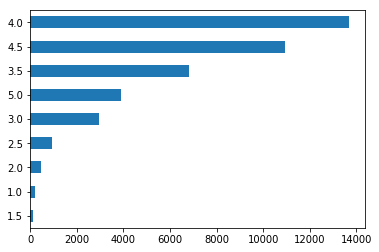

In [28]:
# Посмотрим на значения в этом столбце по df_train 
#  (в части df_test целевой переменной Rating нет)
field_values(df_train,'Rating')
# и распределение целевой переменной
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

Стоит отметить, что это ***Дискретный*** числоловой столбец.

Возможные значения только 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0 <br>
Выше 5 точно не может быть, а вот бывает ли 0.0 и 0.5 - нет данных. 

Позже надо учесть в нашей моделе

### 9 Cuisine_Style

In [29]:
# Посмотрим на значения в этом столбце
field_values(data, 'Cuisine_Style')

# В колонке cuisine_style 11590 (23.18%) пропущенных значений
# Создадим новый булевый столбец Cuisine_Style_nan, чтобы не потерять данные
data['Cuisine_Style_nan'] = pd.isna(data['Cuisine_Style']).astype('uint8')

# Заполним пропуски значением 'Unknown'
data['Cuisine_Style'].fillna("['Unknown']", inplace=True)
# Конвертируем в список.
data['Cuisine_list'] = data['Cuisine_Style'].str.replace(
    r"['\[\]]", '', regex=True).str.split(', ')

# Создадим признак 'Cuisine_count' - количество представленных кухонь в ресторане.
data['Cuisine_count'] = data['Cuisine_list'].str.len()

# Проверяем
#field_values(data,'Cuisine_Style', table=False)
#field_values(data,'Cuisine_count')

Cuisine_Style :  <class 'str'>
Уникальных значений  10731  из 50000
NaN  11590 ( 23.18 % )


['Italian']               1332
['French']                1019
['Spanish']                860
['French', 'European']     503
['Cafe']                   500
['Pizza']                  454
Name: Cuisine_Style, dtype: int64

In [30]:
# Используем One-Hot Encoding для списка созданного из Cuisine_Style
#clist = data['Cuisine_list'].explode().unique()
# Во избежании большого кол-ва не особо значимых столбцов, возьму только несколько.
# MAE при этом почти не изменяется.
clist = ['Portuguese', 'Cafe', 'European', 'Spanish', 'Italian', 'Mediterranean' ]
for cuisine in clist:
    data['cu_' + cuisine.replace(' ','_')] = data['Cuisine_list'].apply(lambda x: 1 if cuisine in x else 0)

In [31]:
# Удалим ненужные столбцы
data.drop(columns=['Cuisine_list', 'Cuisine_Style'], inplace=True)

### 10 City

In [32]:
# Посмотрим на значения в этом столбце
field_values(data,'City')

#city_list = data.city.unique()
# Создадим признак capital: 1 - если наш город столица, 0 - если нет
capital_list = ['Paris', 'Stockholm', 'London', 'Berlin', 'Bratislava',
        'Vienna', 'Rome', 'Madrid', 'Dublin', 'Brussels', 'Warsaw',
        'Budapest', 'Copenhagen', 'Amsterdam', 'Lisbon', 'Prague',
        'Oslo', 'Helsinki', 'Edinburgh', 'Ljubljana', 'Athens',
        'Luxembourg']

data['Capital'] = data['City'].apply(lambda x: 1 if x in capital_list else 0)

# Проверяем
field_values(data, 'Capital')

City :  <class 'str'>
Уникальных значений  31  из 50000
NaN  0 ( 0.0 % )


London       7193
Paris        6108
Madrid       3813
Barcelona    3395
Berlin       2705
Milan        2694
Name: City, dtype: int64

Capital :  <class 'numpy.int64'>
Уникальных значений  2  из 50000
NaN  0 ( 0.0 % )


Capital
0    12017
1    37983
Name: Capital, dtype: int64

In [33]:
# Используем One-Hot Encoding (get_dummies).
# Параметр dummy_na нам здесь не нужен
data = pd.get_dummies(data, columns=['City',])

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

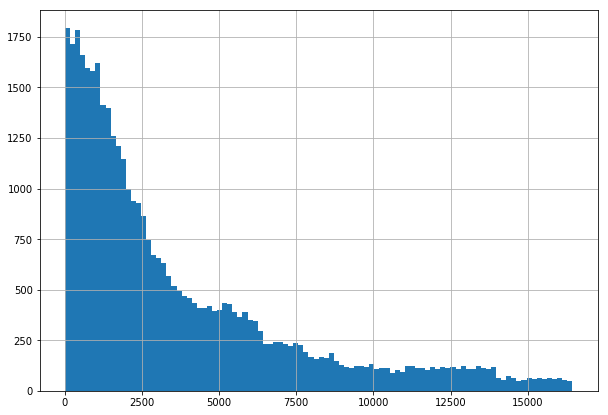

In [34]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

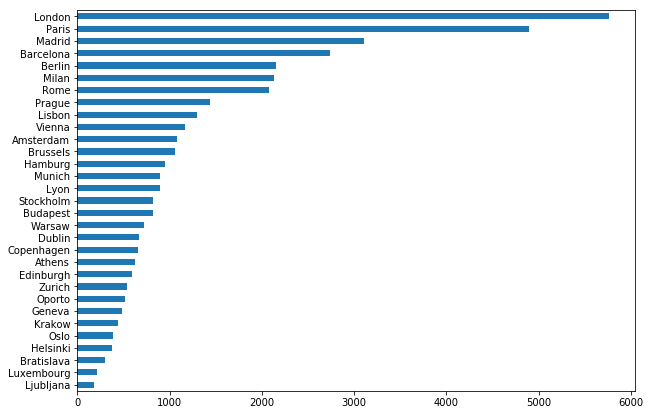

In [35]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

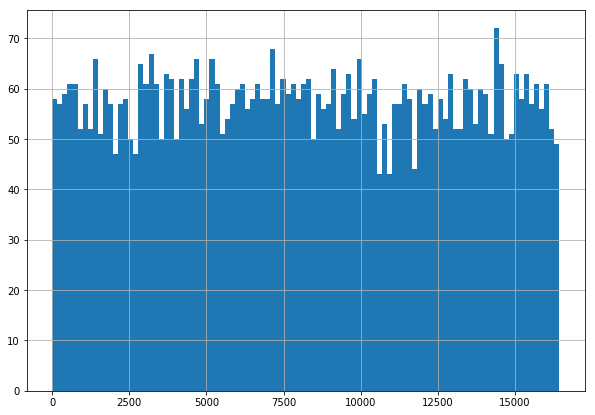

In [36]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

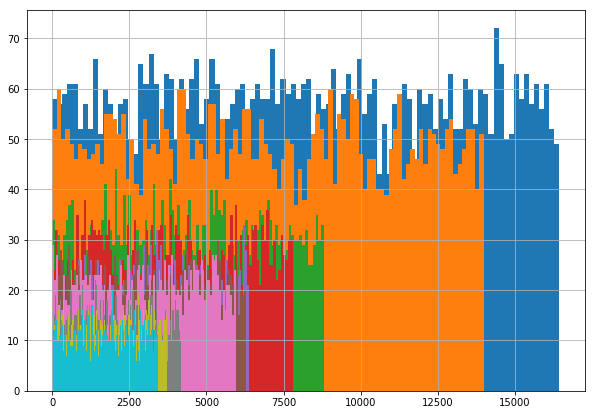

In [37]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

### Посмотрим распределение целевой переменной относительно признака

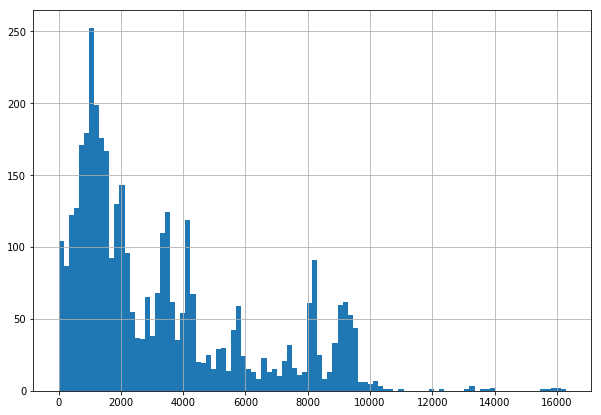

In [38]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

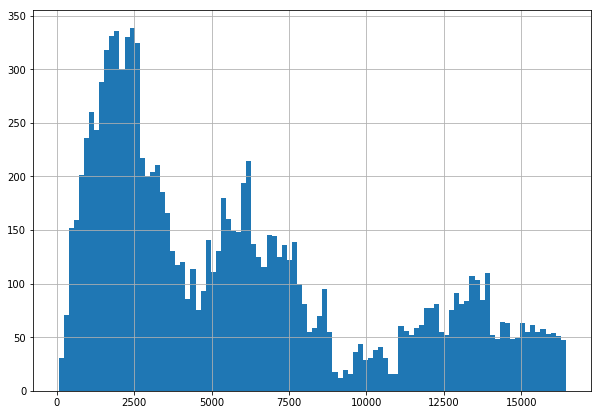

In [39]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

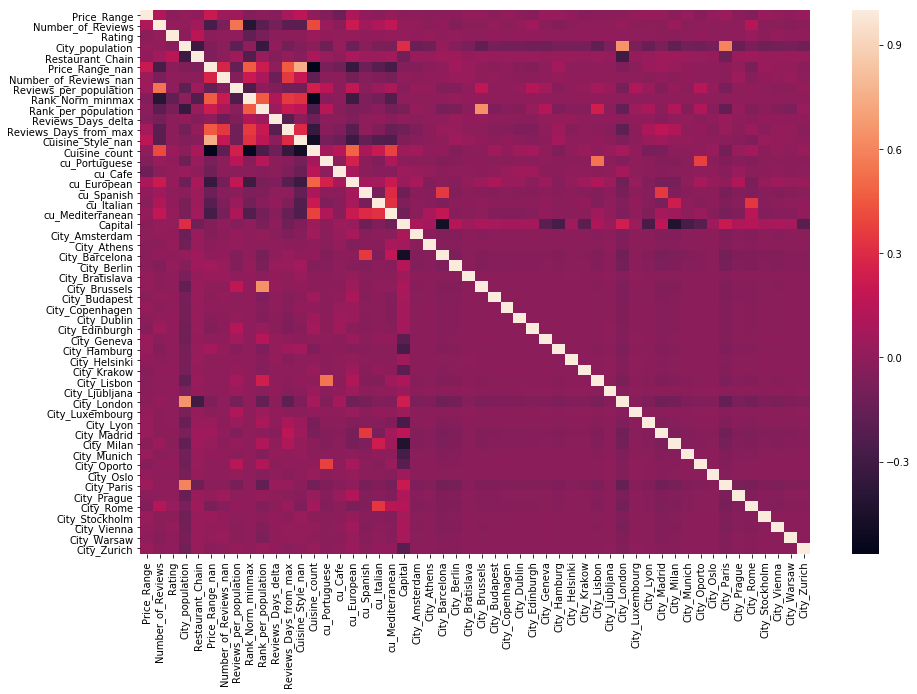

In [40]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

In [41]:
#data[['Reviews_Dates_count','Reviews_Days_from_max']].corr()
#'Reviews_Dates_count','Reviews_Days_from_max'
#data[['Cuisine_count','Price_Range']].corr()

# Data Preprocessing


In [42]:
# Удалим не числовые столбцы
df_preproc = del_object_type(data)
df_preproc.sample(10)

,Price_Range,Number_of_Reviews,sample,Rating,City_population,Restaurant_Chain,Price_Range_nan,Number_of_Reviews_nan,Reviews_per_population,Rank_Norm_minmax,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
32787,2.0,19.0,1,5.0,1324,1,1,1,0.014350,0.474916,...,0,0,0,0,1,0,0,0,0,0
29071,2.0,16.0,1,4.0,1352,1,1,0,0.011834,0.638030,...,0,0,0,0,0,0,0,0,0,0
36963,1.0,56.0,1,3.5,1324,1,0,0,0.042296,0.658863,...,0,0,0,0,1,0,0,0,0,0
20121,2.0,143.0,1,4.0,3266,1,0,0,0.043784,0.372389,...,0,0,0,0,0,0,0,0,0,0
21557,2.0,51.0,1,2.5,516,1,1,0,0.098837,0.944090,...,0,0,0,0,0,0,0,0,0,0
43011,1.0,10.0,1,2.0,488,1,0,0,0.020492,0.939943,...,0,0,0,0,0,0,0,0,0,0
11018,3.0,52.0,1,5.0,3266,1,0,0,0.015922,0.015554,...,0,0,0,0,0,0,0,0,0,0
5143,2.0,3.0,0,0.0,10979,1,1,0,0.000273,0.581038,...,0,0,0,0,0,0,0,0,0,0
11919,2.0,6.0,1,3.5,973,1,1,0,0.006166,0.771417,...,0,0,0,0,0,0,1,0,0,0
16726,1.0,59.0,1,5.0,10979,1,0,0,0.005374,0.126194,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# Убедимся, что остались только числовые колонки
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 53 columns):
Price_Range               50000 non-null float64
Number_of_Reviews         50000 non-null float64
sample                    50000 non-null int64
Rating                    50000 non-null float64
City_population           50000 non-null int64
Restaurant_Chain          50000 non-null int64
Price_Range_nan           50000 non-null uint8
Number_of_Reviews_nan     50000 non-null uint8
Reviews_per_population    50000 non-null float64
Rank_Norm_minmax          50000 non-null float64
Rank_per_population       50000 non-null float64
Reviews_Days_delta        50000 non-null int64
Reviews_Days_from_max     50000 non-null int64
Cuisine_Style_nan         50000 non-null uint8
Cuisine_count             50000 non-null int64
cu_Portuguese             50000 non-null int64
cu_Cafe                   50000 non-null int64
cu_European               50000 non-null int64
cu_Spanish                50000 n

In [44]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [45]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [46]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 52), (40000, 52), (40000, 51), (32000, 51), (8000, 51))

# Model 
Сам ML

In [47]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [48]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [49]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [50]:
# Cоздание функции для векторов np
vector_round = np.vectorize(lambda x: min(np.round(x * 2) / 2, 5))

# Так как признак рейтинга имеет шаг 0.5 и он точно не может быть больше 5, округляем предсказание.
y_pred = vector_round(y_pred)

In [51]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1674375


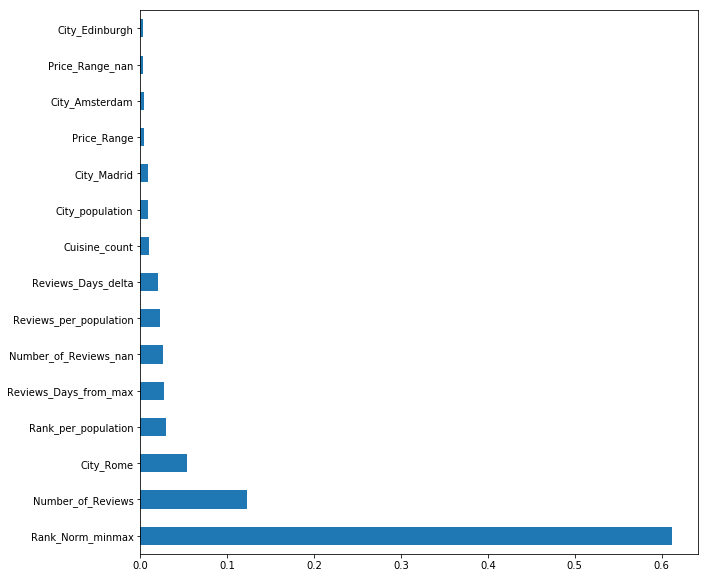

In [52]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

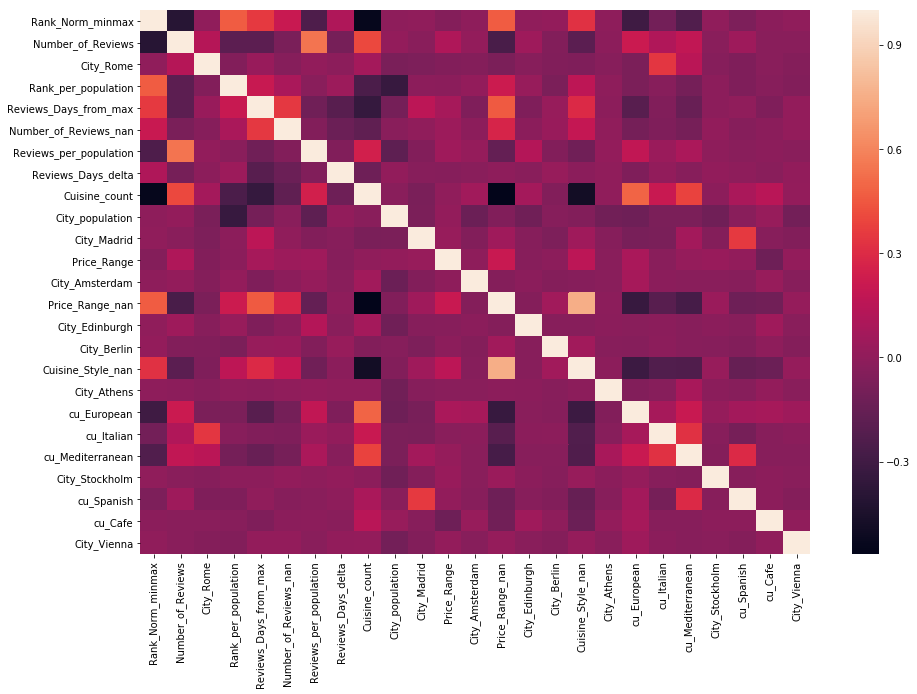

In [53]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data[feat_importances.nlargest(25).index].corr())

In [54]:
#data[feat_importances.nlargest(25).index].corr()

In [55]:
#feat_importances.nlargest(45)
#feat_importances.nlargest(15).index

# Submission
Если все устраевает - готовим Submission на кагл

In [56]:
test_data.sample(10)

,Price_Range,Number_of_Reviews,Rating,City_population,Restaurant_Chain,Price_Range_nan,Number_of_Reviews_nan,Reviews_per_population,Rank_Norm_minmax,Rank_per_population,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
2776,2.0,20.0,0.0,1352,1,1,0,0.014793,0.520720,2.417160,...,0,0,0,0,0,0,0,0,0,0
4360,2.0,114.0,0.0,2873,1,0,0,0.039680,0.282832,0.585799,...,0,0,0,0,0,1,0,0,0,0
8477,2.0,95.0,0.0,3645,0,0,0,0.026063,0.905024,1.582167,...,0,0,0,0,0,0,0,0,0,0
263,2.0,75.0,0.0,642,1,0,0,0.116822,0.054529,0.102804,...,0,0,0,0,0,0,0,0,0,0
4039,2.0,2.0,0.0,122,1,1,0,0.016393,0.651050,3.319672,...,0,0,0,0,0,0,0,0,0,0
1945,2.0,105.0,0.0,2873,1,0,0,0.036547,0.503615,1.042812,...,0,0,0,0,0,1,0,0,0,0
2802,2.0,26.0,0.0,1031,1,0,0,0.025218,0.510298,1.611057,...,0,0,0,0,0,0,0,0,0,0
6286,2.0,187.0,0.0,10979,1,0,0,0.017033,0.392143,0.587394,...,0,0,0,0,0,0,0,0,0,0
2840,2.0,22.0,0.0,3645,1,1,0,0.006036,0.918838,1.606310,...,0,0,0,0,0,0,0,0,0,0
135,2.0,19.0,0.0,1324,1,0,0,0.014350,0.686813,2.172961,...,0,0,0,0,1,0,0,0,0,0


In [57]:
test_data = test_data.drop(['Rating'], axis=1)

In [58]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [59]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [60]:
predict_submission=vector_round(predict_submission)
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [61]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,3.5
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
